In [37]:
#importing librarires

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from torchinfo import summary
from torchvision.datasets import ImageFolder
from collections import Counter


In [38]:
# Define transformations with data augmentation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Load the full dataset from your custom dataset path
full_dataset = ImageFolder(root='/Users/yavar/Desktop/cnn_dataset-1', transform=transform)

# Split the dataset into training (70%), validation (20%), and test (10%) sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [39]:
print(f"Total samples in the dataset: {len(full_dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image size: {full_dataset[0][0].shape[1:]}")  # Assuming all images are the same size
print(f"Number of classes: {len(full_dataset.classes)}")

# Class distribution
from collections import Counter

train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)
print(f"Class distribution in training set: {class_counts}")


Total samples in the dataset: 100800
Training samples: 70560
Validation samples: 20160
Test samples: 10080
Image size: torch.Size([28, 28])
Number of classes: 36
Class distribution in training set: Counter({22: 2037, 34: 2033, 28: 1997, 25: 1994, 5: 1990, 8: 1990, 1: 1983, 7: 1982, 21: 1979, 4: 1974, 10: 1973, 14: 1970, 30: 1967, 33: 1963, 16: 1962, 23: 1961, 12: 1958, 35: 1956, 9: 1956, 17: 1955, 31: 1954, 15: 1949, 24: 1948, 0: 1947, 29: 1945, 32: 1944, 27: 1943, 13: 1942, 6: 1940, 26: 1939, 18: 1933, 19: 1926, 20: 1923, 2: 1921, 11: 1920, 3: 1906})


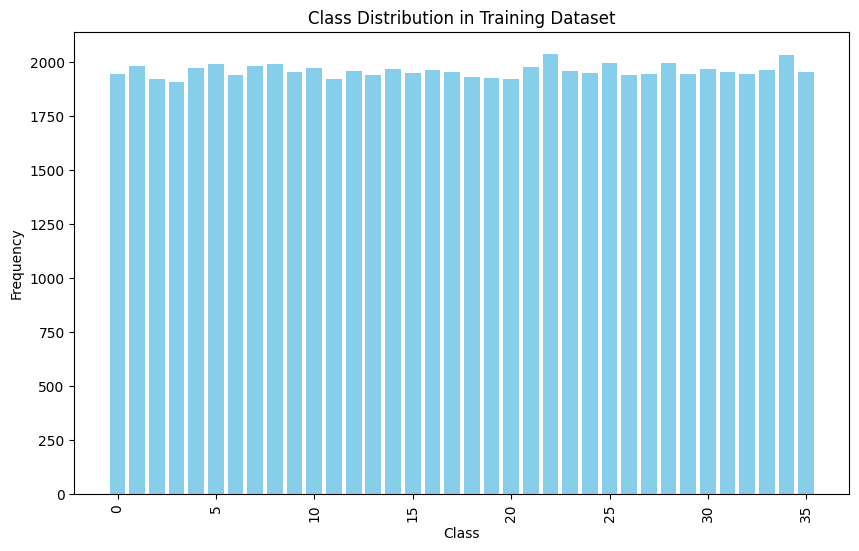

In [40]:
import matplotlib.pyplot as plt

labels = [label for _, label in train_dataset]
label_counts = Counter(labels)

plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


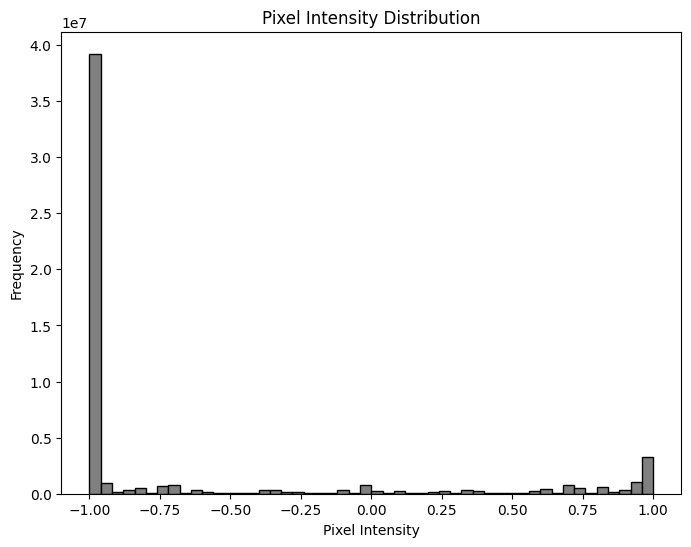

In [41]:
import numpy as np

# Flatten all images in the dataset to calculate pixel intensity distribution
pixel_values = np.concatenate([np.array(image).flatten() for image, _ in train_dataset])

plt.figure(figsize=(8, 6))
plt.hist(pixel_values, bins=50, color='gray', edgecolor='black')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


In [42]:
# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, len(full_dataset.classes))  # Dynamically set output layer based on number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

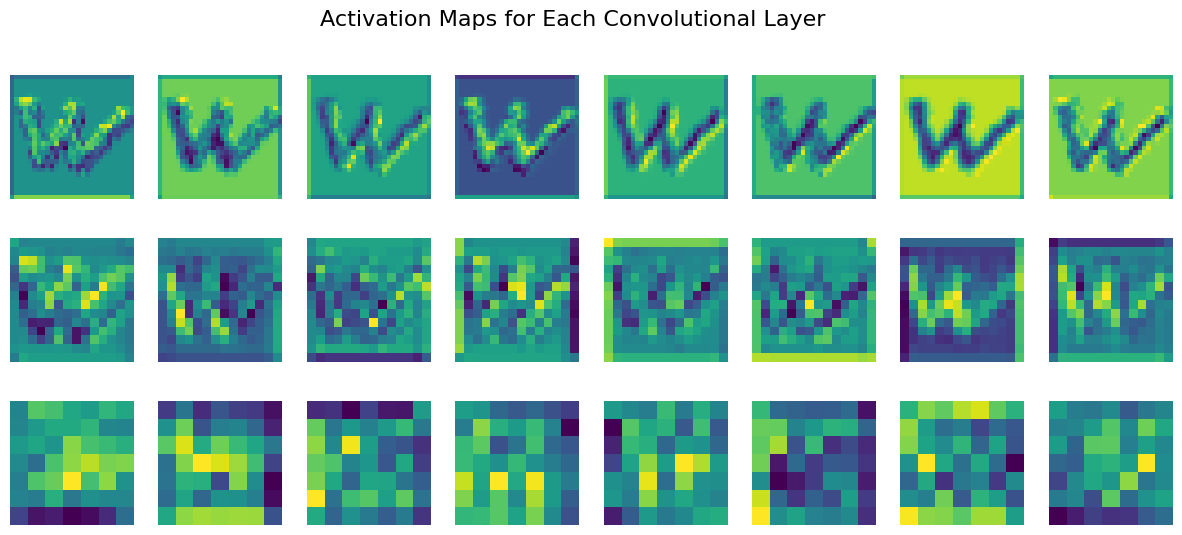

In [43]:
import torch
import matplotlib.pyplot as plt

def visualize_activation_maps(model, image, device):
    model.eval()
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    activation_maps = []

    # Define a hook to capture outputs from each Conv2d layer
    hooks = []
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            hooks.append(layer.register_forward_hook(lambda m, i, o: activation_maps.append(o)))

    # Forward pass through the model with the sample image
    with torch.no_grad():
        _ = model(image)  # Just run the forward pass to trigger hooks

    # Remove hooks after getting activation maps
    for hook in hooks:
        hook.remove()

    # Plot the activation maps for each Conv2d layer
    fig, axes = plt.subplots(len(activation_maps), 8, figsize=(15, 2 * len(activation_maps)))
    for layer_idx, activation in enumerate(activation_maps):
        # Display up to 8 feature maps per layer
        for filter_idx in range(min(8, activation.size(1))):
            ax = axes[layer_idx, filter_idx]
            ax.imshow(activation[0, filter_idx].cpu().numpy(), cmap='viridis')
            ax.axis('off')
    plt.suptitle('Activation Maps for Each Convolutional Layer', fontsize=16)
    plt.show()

# Choose a sample image from the dataset (e.g., the first image)
sample_image, _ = train_dataset[0]

# Call the visualization function
visualize_activation_maps(net, sample_image, device)


In [44]:
# Return the summary of the model using torchinfo
print("Model Summary:")
summary(net, input_size=(64, 1, 28, 28))

Model Summary:


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [64, 36]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─MaxPool2d: 1-2                         [64, 32, 14, 14]          --
├─Conv2d: 1-3                            [64, 64, 14, 14]          18,496
├─MaxPool2d: 1-4                         [64, 64, 7, 7]            --
├─Conv2d: 1-5                            [64, 128, 7, 7]           73,856
├─MaxPool2d: 1-6                         [64, 128, 3, 3]           --
├─Linear: 1-7                            [64, 256]                 295,168
├─Dropout: 1-8                           [64, 256]                 --
├─Linear: 1-9                            [64, 128]                 32,896
├─Dropout: 1-10                          [64, 128]                 --
├─Linear: 1-11                           [64, 36]                  4,644
Total params: 425,380
Trainable params: 425,380
Non-trainable pa

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


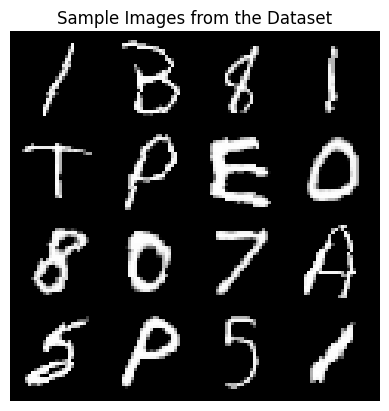

In [45]:
def show_batch(loader):
    images, labels = next(iter(loader))
    grid_img = torchvision.utils.make_grid(images[:16], nrow=4)
    plt.imshow(grid_img.permute(1, 2, 0), cmap="gray")
    plt.title("Sample Images from the Dataset")
    plt.axis('off')
    plt.show()

# Show a batch of images
show_batch(train_loader)

In [46]:
# Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [47]:
# Training, validation, and testing function with model saving and metric tracking
def train_and_evaluate(net, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, epochs=20):
    best_val_accuracy = 0.0
    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    start_time = time.time()  # Start time for training

    for epoch in range(epochs):
        net.train()
        running_loss, correct, total = 0.0, 0, 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_accuracy = 100 * correct / total
        epoch_train_loss = running_loss / len(train_loader)
        train_acc.append(epoch_train_accuracy)
        train_loss.append(epoch_train_loss)

        # Validation loop
        net.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_accuracy = 100 * val_correct / val_total
        epoch_val_loss = val_running_loss / len(val_loader)
        val_acc.append(epoch_val_accuracy)
        val_loss.append(epoch_val_loss)

        # Print progress for each epoch
        print(f"Epoch [{epoch + 1}/{epochs}] - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}% - "
              f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.2f}%")

        # Save the model with the best validation accuracy
        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            torch.save(net.state_dict(), "best_model_part3.pth")

        scheduler.step()

    end_time = time.time()  # End time for training
    training_time = end_time - start_time  # Calculating total training time
    print(f"Training completed in: {training_time:.2f} seconds")

    # Loading the best model for testing
    net.load_state_dict(torch.load("best_model_part3.pth"))
    test_accuracy, test_precision, test_recall, test_f1 = test(net, test_loader)

    return train_acc, val_acc, train_loss, val_loss, training_time, test_accuracy, test_precision, test_recall, test_f1

In [48]:
def test(net, test_loader):
    net.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

    

    # Confusion matrix on test data
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 8})
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title("Confusion Matrix (Test Data)", fontsize=14)
    plt.xticks(ticks=np.arange(len(set(all_labels))) + 0.5, labels=full_dataset.classes, rotation=45, ha="right", fontsize=10)
    plt.yticks(ticks=np.arange(len(set(all_labels))) + 0.5, labels=full_dataset.classes, rotation=0, fontsize=10)
    plt.show()


    # ROC Curve for multi-class classification
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc

    n_classes = len(set(all_labels))
    y_test = label_binarize(all_labels, classes=list(range(n_classes)))
    y_score = label_binarize(all_preds, classes=list(range(n_classes)))

    # Compute ROC curve and ROC area for each class
    plt.figure(figsize=(14, 10))  # Increase figure size
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1.5, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')

    # Position the legend outside the plot area
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0., ncol=1, fontsize='small')  
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for the legend
    plt.show()

    return accuracy, precision, recall, f1

Epoch [1/20] - Train Loss: 1.2120, Train Accuracy: 61.48% - Val Loss: 0.3828, Val Accuracy: 86.73%
Epoch [2/20] - Train Loss: 0.5753, Train Accuracy: 80.46% - Val Loss: 0.3283, Val Accuracy: 87.73%
Epoch [3/20] - Train Loss: 0.4826, Train Accuracy: 83.47% - Val Loss: 0.2946, Val Accuracy: 88.97%
Epoch [4/20] - Train Loss: 0.4312, Train Accuracy: 85.16% - Val Loss: 0.3030, Val Accuracy: 89.04%
Epoch [5/20] - Train Loss: 0.4033, Train Accuracy: 86.15% - Val Loss: 0.2813, Val Accuracy: 89.30%
Epoch [6/20] - Train Loss: 0.3426, Train Accuracy: 87.96% - Val Loss: 0.2543, Val Accuracy: 90.71%
Epoch [7/20] - Train Loss: 0.3238, Train Accuracy: 88.57% - Val Loss: 0.2572, Val Accuracy: 90.69%
Epoch [8/20] - Train Loss: 0.3124, Train Accuracy: 88.84% - Val Loss: 0.2530, Val Accuracy: 91.00%
Epoch [9/20] - Train Loss: 0.3033, Train Accuracy: 89.04% - Val Loss: 0.2540, Val Accuracy: 90.90%
Epoch [10/20] - Train Loss: 0.2985, Train Accuracy: 89.41% - Val Loss: 0.2499, Val Accuracy: 90.97%
Epoch [11

/var/folders/_n/nbbzbnm13nq3c6fcgjjfr8y00000gn/T/ipykernel_19426/2998411674.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("best_model_p

Test Accuracy: 90.83%
Precision: 0.92, Recall: 0.91, F1 Score: 0.91


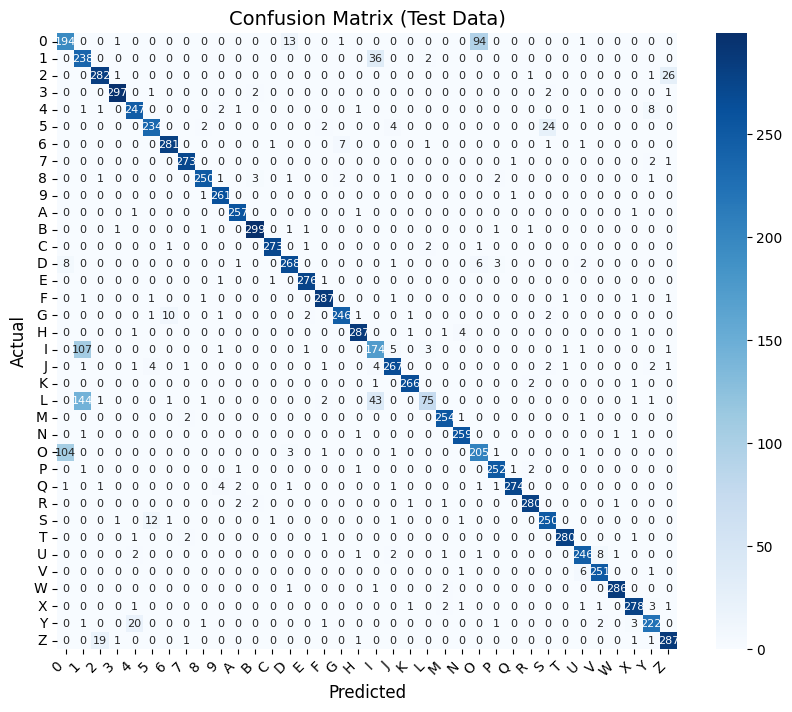

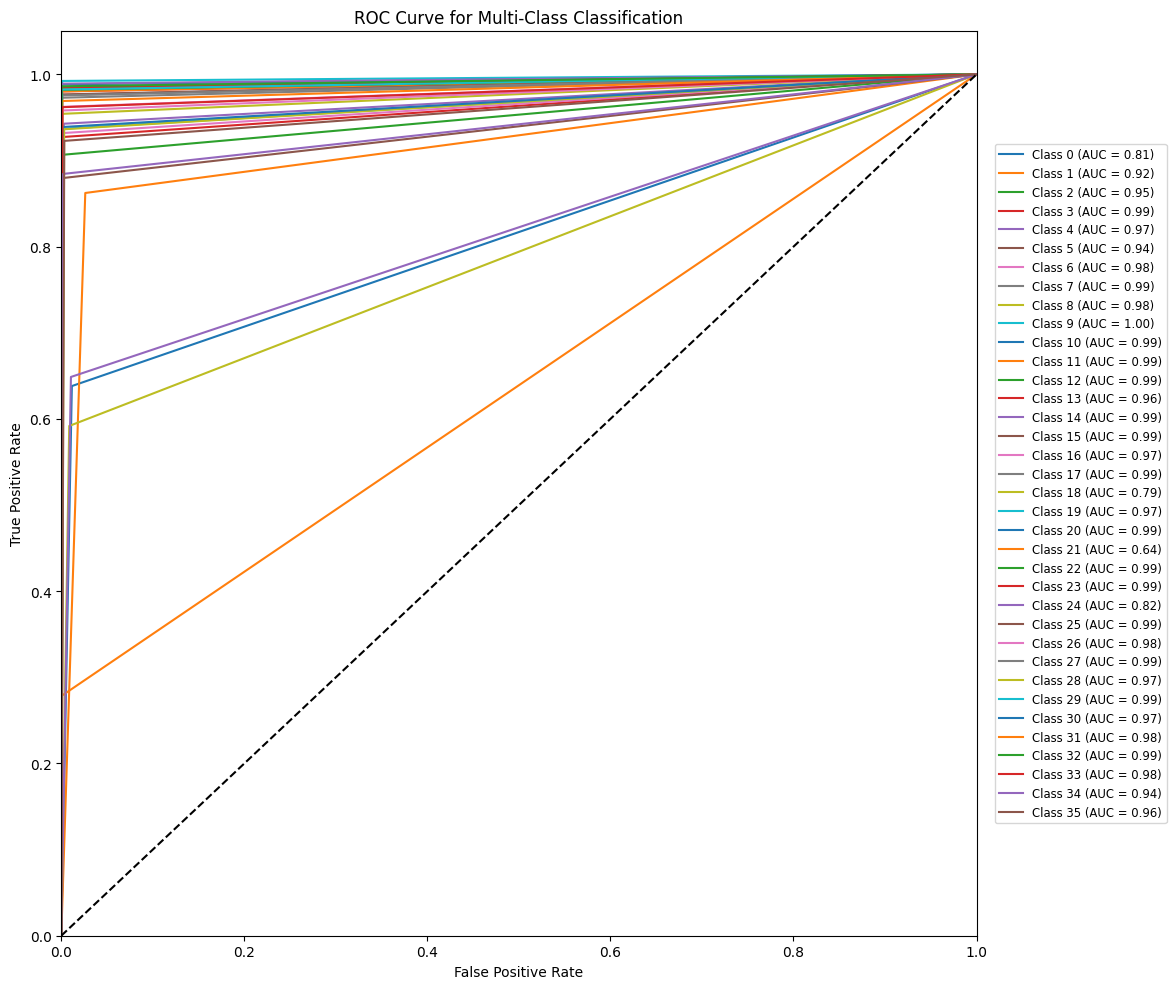

In [49]:
# Train and evaluate the network
train_acc, val_acc, train_loss, val_loss, training_time, test_accuracy, test_precision, test_recall, test_f1 = train_and_evaluate(
    net, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, epochs=20
)

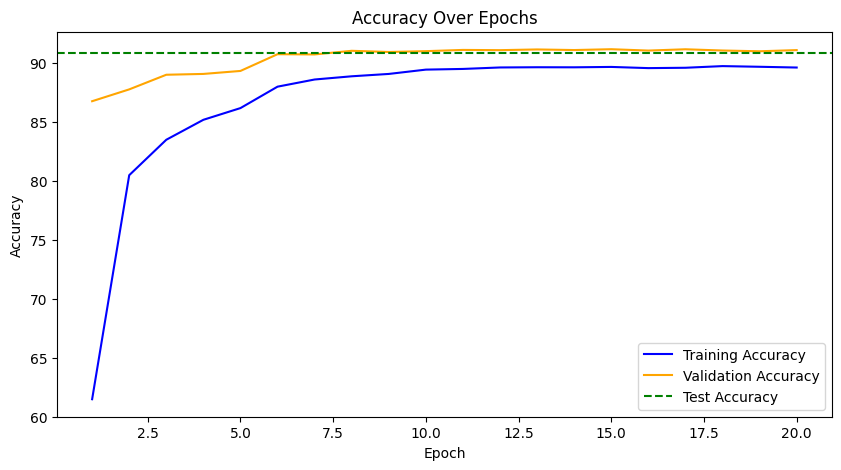

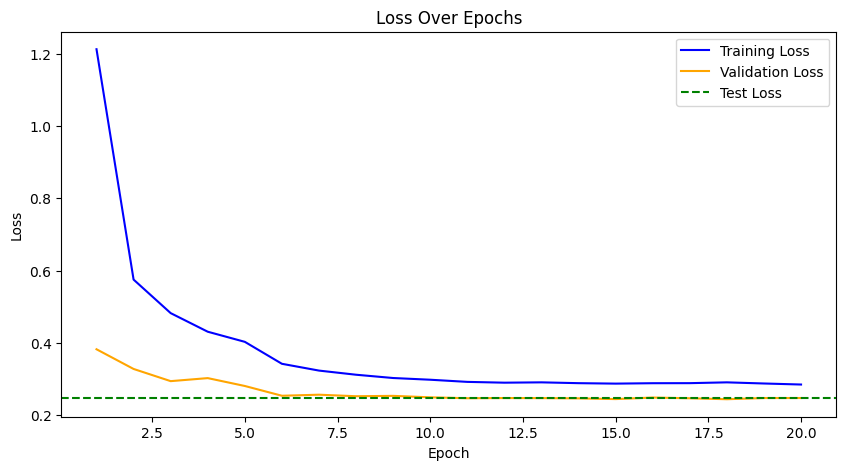

In [50]:
# Visualization of accuracy and loss over epochs
epochs_range = range(1, len(train_acc) + 1)

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc, label="Training Accuracy", color="blue")
plt.plot(epochs_range, val_acc, label="Validation Accuracy", color="orange")
plt.axhline(y=test_accuracy, color='green', linestyle='--', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

# Loss Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss, label="Training Loss", color="blue")
plt.plot(epochs_range, val_loss, label="Validation Loss", color="orange")
plt.axhline(y=val_loss[-1], color='green', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()